# Starter: Text Generation with Keras

Hello people, welcome to this kernel. In this kernel I am gonna generate text using RNNs. I will explain everything step-by-step. Before starting, let's take a look at our content.

# Notebook Content
1. Importing Libraries and The Data
1. Data Overview
1. Data Processing
    * Char Dataset
    * Sequence Dataset
    * Splitting Input and Target
    * Batching
1. Modeling
    * Sequence Model
    * Loss Function and Compiling The Model
    * Fitting Model
1. Evaluating
    * Loading Model
    * Text Generating Function
1. Conclusion

# Importing Libraries and The Data

In this section I am going to import the libraries that I will use.

In [1]:
import tensorflow as tf
import numpy as np
import os 

In [2]:
text = open("../input/war-and-peace-project-gutenberg/war_peace_plain.txt","rb").read().decode("utf-8")
print(text[:1000])


CHAPTER I

“Well, Prince, so Genoa and Lucca are now just family estates of the
Buonapartes. But I warn you, if you don’t tell me that this means war,
if you still try to defend the infamies and horrors perpetrated by that
Antichrist—I really believe he is Antichrist—I will have nothing
more to do with you and you are no longer my friend, no longer my
‘faithful slave,’ as you call yourself! But how do you do? I see I
have frightened you—sit down and tell me all the news.”

It was in July, 1805, and the speaker was the well-known Anna Pávlovna
Schérer, maid of honor and favorite of the Empress Márya Fëdorovna.
With these words she greeted Prince Vasíli Kurágin, a man of high
rank and importance, who was the first to arrive at her reception. Anna
Pávlovna had had a cough for some days. She was, as she said, suffering
from la grippe; grippe being then a new word in St. Petersburg, used
only by the elite.

All her invitations without exception, written in French, and de


# Data Overview

In this section I am going to take a look at the data.

In [3]:
print("There are {} char in the text".format(len(text)))

There are 3266503 char in the text


In [4]:
vocab = sorted(set(text))
print("There are {} unique char in the text".format(len(vocab)))

There are 105 unique char in the text


In [5]:
char2idx = {u:i for i,u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = [char2idx[char] for char in text]

print(text_as_int[:20])

[1, 0, 27, 32, 25, 40, 44, 29, 42, 2, 33, 1, 0, 1, 0, 103, 47, 55, 62, 62]


* I give an index to each unique char. In order to give indexes to chars I've used enumerate function of Python.

# Data Processing

In this section I am going to prepare the dataset in order to use in our future deep learning model.

In [6]:
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for index in char_dataset.take(10):
    if idx2char[index.numpy()] == " ":
        print("SPACE",index.numpy())
    elif idx2char[index.numpy()] == "\n":
        print("\\n",index.numpy())
    else:
        print(idx2char[index.numpy()],index.numpy())
    

 1
\n 0
C 27
H 32
A 25
P 40
T 44
E 29
R 42
SPACE 2


I've sliced the dataset by each char so, each iteration is a character from the text.

In [7]:
seq_length = 100
sequences = char_dataset.batch(seq_length+1,drop_remainder=True)

for item in sequences.take(1):
    
    print(item,end="\n")
    print("\n")
    print(idx2char[item],end="\n")
    print("".join(idx2char[item]))

tf.Tensor(
[  1   0  27  32  25  40  44  29  42   2  33   1   0   1   0 103  47  55
  62  62   7   2  40  68  59  64  53  55   7   2  69  65   2  31  55  64
  65  51   2  51  64  54   2  36  71  53  53  51   2  51  68  55   2  64
  65  73   2  60  71  69  70   2  56  51  63  59  62  75   2  55  69  70
  51  70  55  69   2  65  56   2  70  58  55   1   0  26  71  65  64  51
  66  51  68  70  55  69   9   2  26  71  70], shape=(101,), dtype=int32)


['\r' '\n' 'C' 'H' 'A' 'P' 'T' 'E' 'R' ' ' 'I' '\r' '\n' '\r' '\n' '“' 'W'
 'e' 'l' 'l' ',' ' ' 'P' 'r' 'i' 'n' 'c' 'e' ',' ' ' 's' 'o' ' ' 'G' 'e'
 'n' 'o' 'a' ' ' 'a' 'n' 'd' ' ' 'L' 'u' 'c' 'c' 'a' ' ' 'a' 'r' 'e' ' '
 'n' 'o' 'w' ' ' 'j' 'u' 's' 't' ' ' 'f' 'a' 'm' 'i' 'l' 'y' ' ' 'e' 's'
 't' 'a' 't' 'e' 's' ' ' 'o' 'f' ' ' 't' 'h' 'e' '\r' '\n' 'B' 'u' 'o' 'n'
 'a' 'p' 'a' 'r' 't' 'e' 's' '.' ' ' 'B' 'u' 't']

CHAPTER I

“Well, Prince, so Genoa and Lucca are now just family estates of the
Buonapartes. But


Now, I've created sequences. Each sequences contains 100 chars. I'will use these sequences in order to create input and target.

In [8]:
def split_input_target(chunk):
    """
    A function that converts sequences into input_text and target_text
    """
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text,target_text

dataset = sequences.map(split_input_target)

for input_example,target_example in dataset.take(1):
    
    print("Input Example")
    print("".join(idx2char[input_example.numpy()]))
    print("\n")
    print("Target Example")
    print("".join(idx2char[target_example.numpy()]))



Input Example

CHAPTER I

“Well, Prince, so Genoa and Lucca are now just family estates of the
Buonapartes. Bu


Target Example

CHAPTER I

“Well, Prince, so Genoa and Lucca are now just family estates of the
Buonapartes. But


First I defined a function that converts each chunk into input_text and target_text. In char based models, I generally use this method. 

After that,I applied this function to every chunk.

## Batching

In this section I am going to split dataset into batches. But before batching, I will shuffle the dataset.

In [9]:
BATCH_SIZE = 128
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE,drop_remainder=True)

dataset


<BatchDataset shapes: ((128, 100), (128, 100)), types: (tf.int32, tf.int32)>

# Sequence Model

In this section I am going to build a seqeunce model in order to generate texts. In text generating, we use RNNs. There are many types of RNNs, like Simple RNN, LSTM and GRU.

Simple RNN is the most primitive version of RNN. It has problems, so we don't use it. In this kernel I am going to use GRU as RNN layer. You can also try LSTM. Both are good RNNs.

Before building the model. Let's take a look at the layers that we will use.

### Layers
1. Embedding Layers: In order to create word vectors, we will use this layer.
1. GRU1 : It is the first RNN layer of the model
1. GRU2: It is the second RNN layer of the model
1. GRU3: It is the third RNN layer of the model
1. Dense: It is the output layer of the model.

Now that we know our layers. Let's build and compile the model.


In [10]:
# loading everything
from tensorflow.python.keras.layers import Dense,CuDNNGRU,Embedding
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.callbacks import ModelCheckpoint

In [11]:
# Determining parameters

vocab_size = len(vocab)

# Embedding dimension, size of each word vector
embedding_dim = 256

# Unit number of each GRU
rnn_units = 1024

* Now I am gonna define a function that helps us to build our model.

In [12]:
def build_model(vocab_size,embedding_dim,rnn_units,batch_size):
    
    model = Sequential()
    
    model.add(Embedding(vocab_size,
                       embedding_dim,
                       batch_input_shape=[batch_size,None]))
    
    model.add(CuDNNGRU(rnn_units,
                      return_sequences=True,
                      stateful=True,
                      recurrent_initializer="glorot_uniform"))
    
    model.add(CuDNNGRU(rnn_units,
                      return_sequences=True,
                      stateful=True,
                      recurrent_initializer="glorot_uniform"))
    
    model.add(CuDNNGRU(rnn_units,
                      return_sequences=True,
                      stateful=True,
                      recurrent_initializer="glorot_uniform"))
    
    model.add(Dense(vocab_size))
    
    return model


* Our function is ready, now let's create our model.

In [13]:
model = build_model(vocab_size,
                    embedding_dim,
                    rnn_units,
                   BATCH_SIZE)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (128, None, 256)          26880     
_________________________________________________________________
cu_dnngru (CuDNNGRU)         (128, None, 1024)         3938304   
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (128, None, 1024)         6297600   
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (128, None, 1024)         6297600   
_________________________________________________________________
dense (Dense)                (128, None, 105)          107625    
Total params: 16,668,009
Trainable params: 16,668,009
Non-trainable params: 0
_________________________________________________________________


## Loss Function and Compiling The Model

Now, I will define the loss and after that I will compile the model.

In [14]:
def loss(labels,logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels,logits,from_logits=True)

* We will use sparse categorical cross entropy, here is the formula:

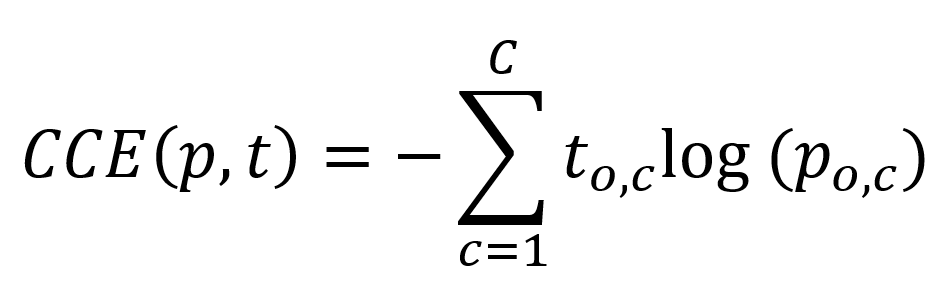

* Let's compile the model.

In [15]:
model.compile(optimizer="rmsprop",loss=loss)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (128, None, 256)          26880     
_________________________________________________________________
cu_dnngru (CuDNNGRU)         (128, None, 1024)         3938304   
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (128, None, 1024)         6297600   
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (128, None, 1024)         6297600   
_________________________________________________________________
dense (Dense)                (128, None, 105)          107625    
Total params: 16,668,009
Trainable params: 16,668,009
Non-trainable params: 0
_________________________________________________________________


Our model has compiled, now there is only one step before fitting the model. Preparing the callback.

In [16]:
# Directory where the checkpoints will be saved

# Creating a folder
os.mkdir('./training_checkpoints')

checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

# Fitting Model

In this section we will fix the model using our prepared dataset. 

In [17]:
EPOCHS = 10
model.fit(dataset,epochs=EPOCHS,callbacks=[checkpoint_callback])

Epoch 1/10
252/252 [==============================] - 57s 226ms/step - loss: 3.1517
Epoch 2/10
252/252 [==============================] - 57s 225ms/step - loss: 2.2377
Epoch 3/10
252/252 [==============================] - 57s 226ms/step - loss: 1.6720
Epoch 4/10
252/252 [==============================] - 57s 226ms/step - loss: 1.4215
Epoch 5/10
252/252 [==============================] - 57s 227ms/step - loss: 1.3191
Epoch 6/10
252/252 [==============================] - 57s 226ms/step - loss: 1.2619
Epoch 7/10
252/252 [==============================] - 57s 225ms/step - loss: 1.2209
Epoch 8/10
252/252 [==============================] - 57s 225ms/step - loss: 1.1881
Epoch 9/10
252/252 [==============================] - 57s 226ms/step - loss: 1.1601
Epoch 10/10
252/252 [==============================] - 57s 226ms/step - loss: 1.1336


# Evaluating Model

In this section I am going to use the trained model. I'll start with rebuilding the model.

## Loading Model
In this section I am going to rebuild model, you know our model takes 64 batches but we want to give only batch. In order to do this, I am going to rebuild model.

In [18]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

* Now let's define a function in order to generate texts.

In [19]:
def generateText(model,start_string,char_size,temp=1.0):
    
    # Length of the text (as char)
    num_generate = char_size
    
    # Converting start string to numbers
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval,0)
    
    text_generated = []
    
    # Low temperature results in more predictable text.
    # Higher temperature results in more surprising text.
    temperature = temp
    
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # Pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

* Finally we came to the funniest stage. Let's create some texts.

In [20]:
print(generateText(model,start_string="CHAPTER 1 \n",char_size=1000))

CHAPTER 1 
What a girl wanted the Twar! What
is the hour, but that we have went from
a wheel: the other had prepared, that is great even
in warxagt tones. You understand her brothers who had never seen an
expedient distance and departure, the reason
with her taste seemed to haut the Kalúga Kurákin and a
shaven hand. The aide-de-camp and shouted and
heward again never had the cheerise voice
unexpressed page leave and shouted with a panic and tried to real what was on duty there was passing
or had getting not to talk away and gave the rapturous and apparent tears from the artner that is given and
truth about yu. Mademoiselle Bourienne we can no is exertion was being cheered her and pregna was very
talk with her that was there could please his presence. But from a handkerchief was bran
 in he saw the corrected the same to her exaggerated, and the joyous step
and felt that the Kerng heapt and obtained her husband in a particular
effect a group when we have true?”

Yet after the whole 


* Text looks good, it does not look meaningful but nice anyway. 
* If you read War and Peace, you will see the characters in this text. Rostov, Natasha and Pierre are characters in the book.
* And I realised one more thing. In book, place names are in Russian and the model confused when it wants to create a place name. 

# Conclusion

Thanks for your attention, if you have questions in your mind, please ask. I will answer your questions as much as I can.